In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
import numpy as np
import cv2
import os
import shutil
import zipfile

In [2]:
def unzip_data():
    print("unzipping")
    zip_path = "data.zip"  # Path to the uploaded zip file in Colab
    extract_path = "Data"  # Extraction path for train and test folders
    if os.path.exists(zip_path):
        print("Unzipping data.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Unzipping completed.")

        nested_angry = "Data/data/angry"
        nested_happy = "Data/data/happy"
        nested_sad = "Data/data/sad"

        if os.path.exists(nested_angry):
            shutil.rmtree(nested_angry)
        if os.path.exists(nested_happy):
            shutil.rmtree(nested_happy)
        if os.path.exists(nested_sad):
            shutil.rmtree(nested_sad)
        print_classes("Data")

        #print_classes(extract_path/test)
    else:
        print(f"Error: {zip_path} not found!")

In [3]:
def print_classes(directory):
    classes = os.listdir(directory)
    print(f"classes found in '{directory}':")
    for cls in classes:
        print(f"- {cls}")

In [4]:
# Step 1: Data Preparation and Loading
def load_data():
    unzip_data()

    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'Data/data/train',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        color_mode='rgb'
    )

    test_generator = test_datagen.flow_from_directory(
        'Data/data/test',
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        color_mode='rgb'
    )
    return train_generator, test_generator

In [5]:
# Step 2: Model Definition (Transfer Learning using VGG16)
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation='softmax')(x)  # 3 emotion classes

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Step 3: Train the Model
def train_model(model, train_generator, validation_generator):
    model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10
    )
    model.save('emotion_model.h5')
    print("Model saved as 'emotion_model.h5'")

In [7]:
# Step 4: Load the Trained Model
def load_trained_model():
    return load_model('emotion_model.h5')

In [8]:
# Step 5: Emotion Prediction
from google.colab.patches import cv2_imshow # Import cv2_imshow
emotion_labels = ['angry', 'happy', 'sad']
def predict_emotion(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image

    # Predict the emotion
    prediction = model.predict(img)
    emotion = emotion_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"Predicted Emotion: {emotion} ({confidence:.2f}%)")

    # Display the image with the predicted emotion
    image = cv2.imread(image_path)
    cv2.putText(image, f'Emotion: {emotion}', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(image) # Use cv2_imshow instead of cv2.imshow

In [10]:
# Step 6: Main Execution
if __name__ == "__main__":
    # Check if the model file exists
    if not os.path.exists('emotion_model.h5'):
        print("Training new model...")
        train_generator, validation_generator = load_data()
        model = create_model()
        train_model(model, train_generator, validation_generator)
    else:
        print("Loading existing model...")
        model = load_trained_model()

Training new model...
unzipping
Unzipping data.zip...


BadZipFile: File is not a zip file

Enter the image file path: saddd_man.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Emotion: angry (57.09%)


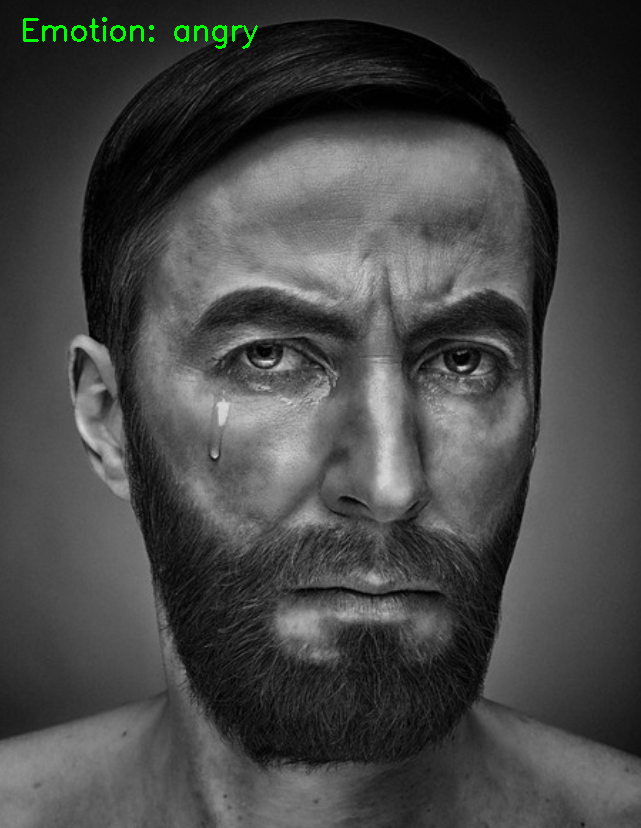

In [ ]:
# Predict emotion from an image
image_path = input("Enter the image file path: ")
predict_emotion(image_path, model)